In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


let's import and put the train and test datasets in  pandas dataframe

In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


check the numbers of samples and features

In [3]:
print(f'training dataset shape before dropping Id column: {train_df.shape}')
print(f'testing dataset shape before dropping Id column: {test_df.shape}')

train_Id = train_df['Id']
test_Id = test_df['Id']

train_df.drop(columns=['Id'], inplace = True)
test_df.drop(columns=['Id'], inplace = True)

print(f'training dataset shape after dropping Id column: {train_df.shape}')
print(f'testing dataset shape after dropping Id column: {test_df.shape}')

training dataset shape before dropping Id column: (1460, 81)
testing dataset shape before dropping Id column: (1459, 80)
training dataset shape after dropping Id column: (1460, 80)
testing dataset shape after dropping Id column: (1459, 79)


# Data Processing

**Outliers**

Ames Housing Data has outliers present in the training data

let's explore these outliers

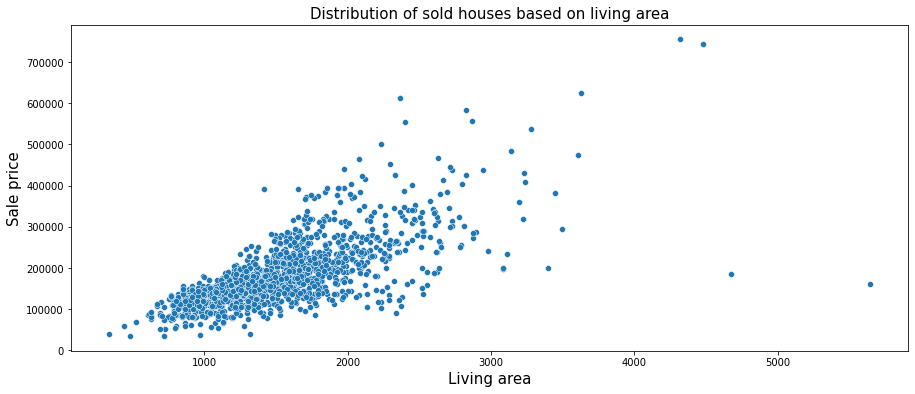

In [4]:
plt.figure(figsize=(15,6))

sns.scatterplot(x = train_df['GrLivArea'], y = train_df['SalePrice'])

plt.xlabel("Living area", fontsize = 15)
plt.ylabel('Sale price', fontsize = 15)
plt.title('Distribution of sold houses based on living area', fontsize = 15)

plt.show()

we can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers (low sale price for huge living area), hence we can safely delete them

In [5]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

check the graphic again

Note : outliers removal is note always safe. We decided to delete these two as they are very huge and really bad (large area for very low price)

There are probably others outliers in the training data. However, removing them all may affect badly our models in the future. That's why, instead of removing them all, we will just manage to make some of our models robust on them

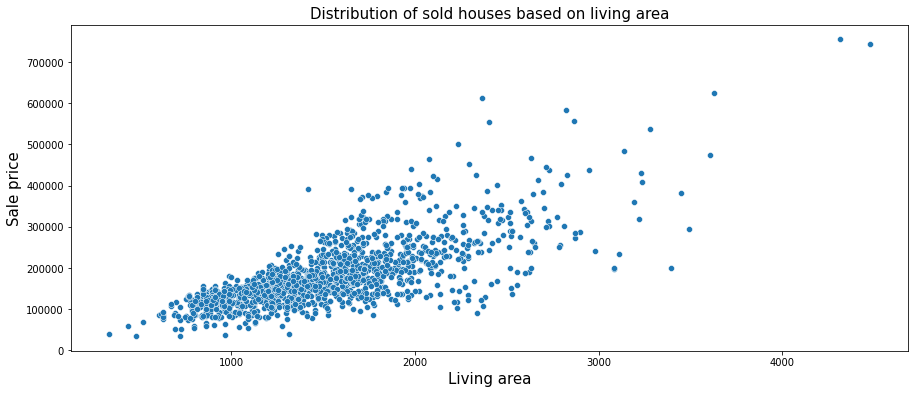

In [6]:
plt.figure(figsize=(15,6))

sns.scatterplot(x = train_df['GrLivArea'], y = train_df['SalePrice'])

plt.xlabel("Living area", fontsize = 15)
plt.ylabel('Sale price', fontsize = 15)
plt.title('Distribution of sold houses based on living area', fontsize = 15)

plt.show()

**Target Variable**

**SalePrice** is the variable we need to predict

the target variable is right skewed. As linear models love normally distributed data, we need to transform this variable and make it more normally distributed

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


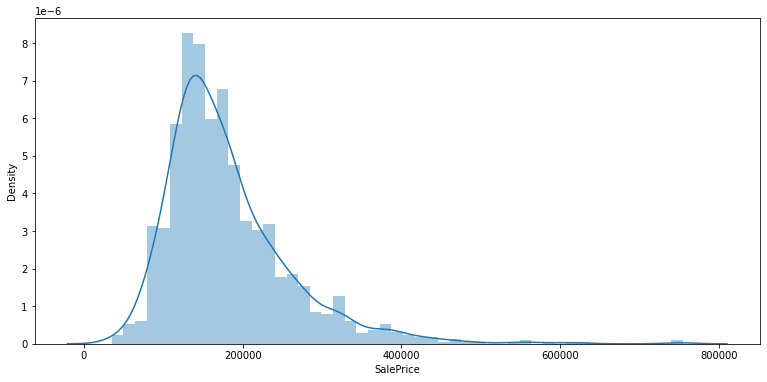

In [7]:
plt.figure(figsize=(13,6))

sns.distplot(train_df['SalePrice'])

plt.show()

we will use the numpy fuction log1p which  applies log(1+x) to all elements of the column

<Figure size 936x432 with 0 Axes>

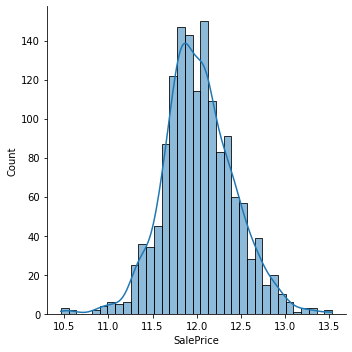

In [8]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(13,6))

sns.displot(train_df['SalePrice'], kde = True)

plt.show()

the skew seems now corrected and the data appears more normally distributed

**Features engineering**

let's start from missing data of training data and test data

training data missing values

In [9]:
null_train = train_df.isnull().sum().sort_values(ascending = False) / len(train_df) * 100
ntr = null_train.head(19)
ntr

PoolQC          99.588477
MiscFeature     96.296296
Alley           93.758573
Fence           80.727023
FireplaceQu     47.325103
LotFrontage     17.764060
GarageYrBlt      5.555556
GarageCond       5.555556
GarageType       5.555556
GarageFinish     5.555556
GarageQual       5.555556
BsmtExposure     2.606310
BsmtFinType2     2.606310
BsmtCond         2.537723
BsmtQual         2.537723
BsmtFinType1     2.537723
MasVnrArea       0.548697
MasVnrType       0.548697
Electrical       0.068587
dtype: float64

test data missing values

In [10]:
null_test = test_df.isnull().sum().sort_values(ascending = False) / len(test_df) * 100
nt = null_test.head(33)
nt

PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageYrBlt      5.346127
GarageFinish     5.346127
GarageQual       5.346127
GarageCond       5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType2     2.878684
BsmtFinType1     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
Functional       0.137080
BsmtHalfBath     0.137080
BsmtFullBath     0.137080
Utilities        0.137080
KitchenQual      0.068540
SaleType         0.068540
BsmtFinSF1       0.068540
GarageCars       0.068540
BsmtUnfSF        0.068540
TotalBsmtSF      0.068540
Exterior2nd      0.068540
Exterior1st      0.068540
GarageArea       0.068540
BsmtFinSF2       0.068540
dtype: float64

let's visualize our missing data

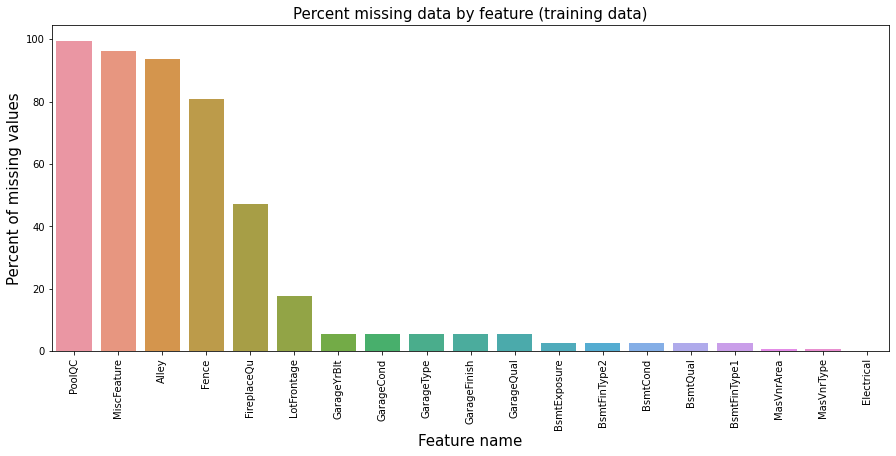

In [11]:
plt.figure(figsize = (15, 6))
sns.barplot(x= ntr.index, y= ntr)

plt.xticks(rotation = 90)
plt.xlabel('Feature name', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature (training data)', fontsize = 15)

plt.show()

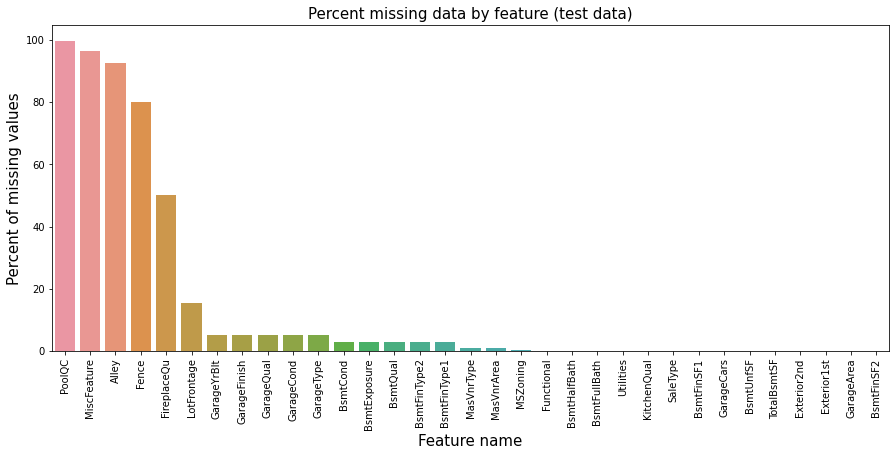

In [12]:
plt.figure(figsize = (15, 6))
sns.barplot(x= nt.index, y= nt)

plt.xticks(rotation = 90)
plt.xlabel('Feature name', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature (test data)', fontsize = 15)

plt.show()

**Imputing missing values**

we impute them by proceeding sequentially through features with missing values

* **PoolQC** : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses don't have pools at all

In [13]:
train_df['PoolQC'] = train_df['PoolQC'].fillna('None')
test_df['PoolQC'] = test_df['PoolQC'].fillna('None')

* **MiscFeature** : data description says NA means "no misc feature"

In [14]:
train_df['MiscFeature'] = train_df['MiscFeature'].fillna('None')
test_df['MiscFeature'] = test_df['MiscFeature'].fillna('None')

* **Alley** : data description says NA means "no alley access"

In [15]:
train_df['Alley'] = train_df['Alley'].fillna('None')
test_df['Alley'] = test_df['Alley'].fillna('None')

* **Fence** : data description says NA means "no fence"

In [16]:
train_df['Fence'] = train_df['Fence'].fillna('None')
test_df['Fence'] = test_df['Fence'].fillna('None')

* **FireplaceQu** : data description says NA means "no fireplace"

In [17]:
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('None')
test_df['FireplaceQu'] = test_df['FireplaceQu'].fillna('None')

* **LotFrontage** : since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood

In [18]:
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) # https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

* **GarageType, GarageFinish, GarageQual and GarageCond** : replacing missing data with None

In [19]:
for garage in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train_df[garage] = train_df[garage].fillna('None')
    
for garage in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test_df[garage] = test_df[garage].fillna('None')

* **GarageYrBlt, GarageArea and GarageCars** : replacing missing data with 0 (Since no garage = no cars in garage)

In [20]:
for garage in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_df[garage] = train_df[garage].fillna(0)
    
for garage in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test_df[garage] = test_df[garage].fillna(0)

* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [21]:
for bsmt in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train_df[bsmt] = train_df[bsmt].fillna(0)
    
for bsmt in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test_df[bsmt] = test_df[bsmt].fillna(0)

* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : for all these categorical basement-related features, NaN means that there is no basement

In [22]:
for bsmt in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_df[bsmt] = train_df[bsmt].fillna('None')
    
for bsmt in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test_df[bsmt] = test_df[bsmt].fillna('None')

* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type

In [23]:
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)
train_df["MasVnrType"] = train_df["MasVnrType"].fillna("None")

test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(0)
test_df["MasVnrType"] = test_df["MasVnrType"].fillna("None")

* **MSZoning (The general zoning classification)** : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [24]:
test_df['MSZoning'] = test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])

* **Utilities** : for this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA. Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it

In [25]:
train_df = train_df.drop(columns = ['Utilities'])
test_df = test_df.drop(columns = ['Utilities'])

* **Functional** : data description says NA means typical

In [26]:
test_df["Functional"] = test_df["Functional"].fillna("Typ")

* **Electrical** : it has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value

In [27]:
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

* **KitchenQual**: only has one NA value and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual

In [28]:
test_df['KitchenQual'] = test_df['KitchenQual'].fillna(test_df['KitchenQual'].mode()[0])

* **Exterior1st and Exterior2nd** : both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [29]:
test_df['Exterior1st'] = test_df['Exterior1st'].fillna(test_df['Exterior1st'].mode()[0])
test_df['Exterior2nd'] = test_df['Exterior2nd'].fillna(test_df['Exterior2nd'].mode()[0])

* **SaleType** : fill in again with most frequent which is "WD"

In [30]:
test_df['SaleType'] = test_df['SaleType'].fillna(test_df['SaleType'].mode()[0])

is there any remaining missing value ?

train dataset

In [31]:
chtr = train_df.isnull().sum().sort_values(ascending = False) / len(train_df) * 100
chtr.head()

MSSubClass      0.0
KitchenAbvGr    0.0
GarageYrBlt     0.0
GarageType      0.0
FireplaceQu     0.0
dtype: float64

test dataset

In [32]:
chts = test_df.isnull().sum().sort_values(ascending = False) / len(test_df) * 100
chts.head()

MSSubClass      0.0
BedroomAbvGr    0.0
GarageType      0.0
FireplaceQu     0.0
Fireplaces      0.0
dtype: float64

**More features engeneering**

transforming some numerical variables that are really categorical

In [33]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)
test_df['MSSubClass'] = test_df['MSSubClass'].apply(str)

train_df['OverallCond'] = train_df['OverallCond'].astype(str)
test_df['OverallCond'] = test_df['OverallCond'].astype(str)

train_df['YrSold'] = train_df['YrSold'].astype(str)
test_df['MoSold'] = test_df['MoSold'].astype(str)

**Adding one more important feature**

since area related features are very important to determine house price, we add one more feature which is the total area of basement, first and second floor area of each house

In [34]:
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

concatenate the train and test data in the same dataframe

In [35]:
all_data = pd.concat([train_df, test_df]).reset_index(drop = True)
all_data = all_data.drop(columns=['SalePrice'])

make a list of categorical features and numerical features

In [36]:
all_data_cat = list(all_data.select_dtypes(include=['object']))
all_data_num = list(all_data.select_dtypes(include=['int', 'float']))

importing libraries for modelling and method for dealing with categorical features

In [37]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge

getting dummy categorical features

In [38]:
all_data = pd.get_dummies(all_data)

finding skewed data

In [39]:
skewness = all_data[all_data_num].skew().sort_values(ascending = False)
skew = skewness[abs(skewness) > 1]

using sqrt method to reduce skewness in data

In [40]:
for x in skew.index:
    all_data[x] = np.sqrt(all_data[x])

our features and target variables

In [41]:
train_X = all_data[:train_df.shape[0]]
test_X = all_data[test_df.shape[0]-1:]
train_y = train_df['SalePrice']

we use the cross_val_score function from Sklearn. However this function has not a shuffle attribute, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [42]:
def rmsle(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=42).get_n_splits(train_X)
    rmse = np.sqrt(-cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

**Base models**

* **LASSO Regression** : this model may be very sensitive to outliers. So we need to make it more robust to them. For that we use the sklearn's Robustscaler() method with pipeline

In [43]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

* **Elastic Net Regression** : again made robust to outliers

In [44]:
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

* **Gradient Boosting Regression** : with huber loss that makes it robust to outliers, hyper parameters were picked with gridsearchcv method

In [45]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_features='sqrt', max_depth = 4,
                                   loss='huber', random_state = 5,
                                  min_samples_leaf = 15, min_samples_split = 10)

* **Kernel Ridge Regression** :

In [46]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* **Random Forest Regressor** : hyperparameters were picked with gridsearchcv method

In [47]:
random_fr = RandomForestRegressor(n_estimators = 2200, random_state = 10, 
                                  max_depth = 6, min_samples_split = 5, min_samples_leaf = 5)

**Base models scores**

let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [48]:
score = rmsle(lasso)
print(f'mean cross validation error score of lasso: {score.mean():.4f}')
score = rmsle(enet)
print(f'mean cross validation error score of elastic net: {score.mean():.4f}')
score = rmsle(gboost)
print(f'mean cross validation error score of gradient boosting: {score.mean():.4f}')
score = rmsle(KRR)
print(f'mean cross validation error score of kernel ridge: {score.mean():.4f}')
score = rmsle(random_fr)
print(f'mean cross validation error score of random forest: {score.mean():.4f}')

mean cross validation error score of lasso: 0.1103
mean cross validation error score of elastic net: 0.1102
mean cross validation error score of gradient boosting: 0.1181
mean cross validation error score of kernel ridge: 0.2838
mean cross validation error score of random forest: 0.1487


In [49]:
from sklearn.ensemble import StackingRegressor

stacking basic models into one, base is lasso model

In [50]:
estimators = [
    ('lasso', lasso),
    ('enet', enet),
    ('krr', KRR),
    ('gboost', gboost),
    ('rf', random_fr)
]

fin = StackingRegressor(estimators = estimators, final_estimator = lasso, cv = 5)

cross validation error of stacked model

In [51]:
score_fin = rmsle(fin)
print(f'mean cross validation error score of stacked regression model: {score_fin.mean():.4f}')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016983753201461838, tolerance: 0.015227603980034471
  positive)


mean cross validation error score of stacked regression model: 0.1092


fitting train data into final stacked model

In [52]:
fin.fit(train_X, train_y)

y_pred_train = fin.predict(train_X)
print('mean squared error:', mean_squared_error(train_y, y_pred_train))

mean squared error: 0.006527470023797142


predicting values for test data and using exmp1, because need to revert from log

In [53]:
values = np.expm1(fin.predict(test_X))

getting submission file

In [54]:
sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = values

In [55]:
sub.to_csv('submission.csv',index=False)